# Задание 1. A/B–тестирование

###  1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.


In [1]:
# подключение библиотек
import pandas as pd
import requests
from urllib.parse import urlencode
import json
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from scipy import stats
plt.style.use('ggplot')

## Импорт данных

In [2]:
# счивание .csv файлов с Яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_groups = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
public_key_active_studs = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
public_key_checks = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'
final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))  # формирование url
response_groups = requests.get(final_url_groups)  # запрос на извлечение данных по указанному url
download_url_groups = json.loads(response_groups.text)['href']  # парсинг данных
groups = pd.read_csv(download_url_groups, sep=';')  # считывание данных в формате dataframe
final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs))
response_active_studs = requests.get(final_url_active_studs)
download_url_active_studs = json.loads(response_active_studs.text)['href']
active_studs = pd.read_csv(download_url_active_studs, sep=';')
final_url_checks = base_url + urlencode(dict(public_key=public_key_checks))
response_checks = requests.get(final_url_checks)
download_url_checks = json.loads(response_checks.text)['href']
checks = pd.read_csv(download_url_checks, sep=';')

In [3]:
# для удабства использования циклов завел Кортежи
df_list = (groups, active_studs, checks)
name_list = ('groups', 'active_studs', 'checks')

In [4]:
# посмотрим наши данные
for i in range(len(df_list)):
    print(name_list[i])
    print(df_list[i].head(3))
    print()

groups
     id grp
0  1489   B
1  1627   A
2  1768   B

active_studs
   student_id
0      581585
1     5723133
2     3276743

checks
   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0



In [5]:
# посмотрим количество данных
for i in range(len(df_list)):
    print(name_list[i], df_list[i].shape)
    print()

groups (74484, 2)

active_studs (8341, 1)

checks (541, 2)



In [6]:
# посмотрим количество пропущенных значений
for i in range(len(df_list)):
    print(name_list[i], df_list[i].isna().sum())
    print()

groups id     0
grp    0
dtype: int64

active_studs student_id    0
dtype: int64

checks student_id    0
rev           0
dtype: int64



In [7]:
# посмотрим количество дубликатов
for i in range(len(df_list)):
    print(name_list[i], df_list[i].duplicated().sum())
    print()

groups 0

active_studs 0

checks 0



In [8]:
# посмотрим посмотрим распределение по группам в первом и во втором файле
for i in range(len(df_list) - 2):
    print(name_list[i])
    print(df_list[i].grp.value_counts() / df_list[i].shape[0] * 100)
    print()

groups
B    80.303152
A    19.696848
Name: grp, dtype: float64



## Обьеденим таблицы для анализа. 

In [9]:
# Переименуем колонку student_id в id
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

In [10]:
# Создадим новую таблицу для ARPPU с пользователями, которые совершили покупки во время проведения эксперимента 
active_checks = checks.merge(active_studs, how='left', on='id')

In [11]:
active_checks.shape

(541, 2)

In [12]:
active_checks = active_checks.merge(groups, how='left', on='id')

In [13]:
active_checks.shape

(541, 3)

In [14]:
active_checks.head(2)

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,B


## Далее я беру данные только активных пользователей за время эксперимента,
## чтобы исключить действия сезонности и возможного влияния других экспериментов.


In [15]:
# Создадим таблицу с пользователями, которые были активны во время эксперимента, 
# пропуски будут говорить об отсутствии покупки.
checks_active_studs = active_studs.merge(checks, how='left', on='id')

In [16]:
checks_active_studs.head(2)

,id,rev
0,581585,NaN
1,5723133,NaN


In [17]:
checks_active_studs.shape

(8341, 2)

In [18]:
# Заменим пропуски (где не совершались покупки) нулями.
checks_active_studs = checks_active_studs.fillna(0)

In [19]:
# Создадим новую колонку в которой 1 = покупка, а 0 = отсутствие покупки.
checks_active_studs['purchase'] = checks_active_studs.rev.apply(lambda x: 1 if x != 0 else 0)

In [20]:
checks_active_studs.shape

(8341, 3)

In [21]:
checks_active_studs.head(3)

,id,rev,purchase
0,581585,0.0,0
1,5723133,0.0,0
2,3276743,0.0,0


In [22]:
# Добавим данные принадлежности к группам в таблицу с пользователями с покупками.
active_groups_checks = checks_active_studs.merge(groups, how='inner', on='id')

In [23]:
active_groups_checks.shape

(8328, 4)

In [24]:
active_groups_checks.head(2)

,id,rev,purchase,grp
0,581585,0.0,0,A
1,3276743,0.0,0,B


In [25]:
# посмотрим посмотрим распределение контрольных и целевых групп
print(active_groups_checks.grp.value_counts() / active_groups_checks.shape[0] * 100)

B    81.568204
A    18.431796
Name: grp, dtype: float64


In [26]:
# посмотрим посмотрим распределение контрольных и целевых групп
print(active_groups_checks.grp.value_counts())

B    6793
A    1535
Name: grp, dtype: int64


# Для анализа я из метрик выбрал конверсию в покупку , средний чек и ARPPU.
# Это наиболее интересные целевые метрики
CR (Conversion rate) - коэффициент конверсии, характеризующий соотношение покупающих пользователей ко всем активным в период эксперимента.

ARPPU (Average Revenue Per Paying User) - средний доход, который приносит платящий пользователь.

## Посмотрим на распределение покупок в тестовой и контрольной группе.

In [27]:
# посмотрим статистики по группам
print('Контрольная группа "A"')
print(active_groups_checks[active_groups_checks.grp == 'A'].describe())
print('Целевая группа "B"')
print(active_groups_checks[active_groups_checks.grp == 'B'].describe())

Контрольная группа "A"
                 id          rev     purchase
count  1.535000e+03  1535.000000  1535.000000
mean   2.448344e+06    47.439739     0.050814
std    1.584452e+06   290.766992     0.219690
min    1.627000e+03     0.000000     0.000000
25%    1.116413e+06     0.000000     0.000000
50%    2.070805e+06     0.000000     0.000000
75%    3.725562e+06     0.000000     0.000000
max    5.690284e+06  3660.000000     1.000000
Целевая группа "B"
                 id          rev     purchase
count  6.793000e+03  6793.000000  6793.000000
mean   2.442220e+06    57.864567     0.046077
std    1.555338e+06   313.197487     0.209667
min    2.085000e+03     0.000000     0.000000
25%    1.118614e+06     0.000000     0.000000
50%    2.088960e+06     0.000000     0.000000
75%    3.611806e+06     0.000000     0.000000
max    5.689627e+06  4650.000000     1.000000


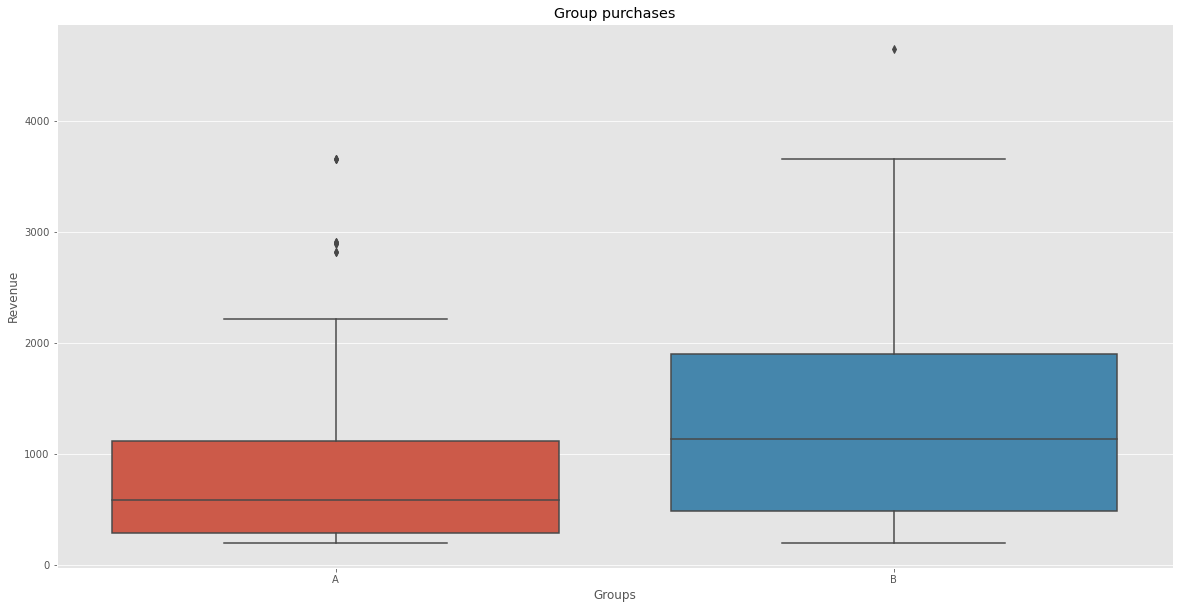

In [28]:
# боксплот распределения покупок по группам среди всех пользователей
plt.figure(figsize=(20, 10))
sns.boxplot(x='grp', y='rev', data=active_groups_checks.query('rev!=0'))
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.title("Group purchases")
plt.show()

Из графиков боксплот мы видим, что в наших данных есть выбросы, значит применение Т-критерия будет не правильным 
(Т-критерий сравнивает средние в распределениях, а выбросы сильно влияют на значение среднего). 

Удалять выбросы неправильно, т.к. мы удалим из анализа так называемых КИТОВ.

Так же из-за выбросов сравнение средних в наших выборках будет не корректно. 


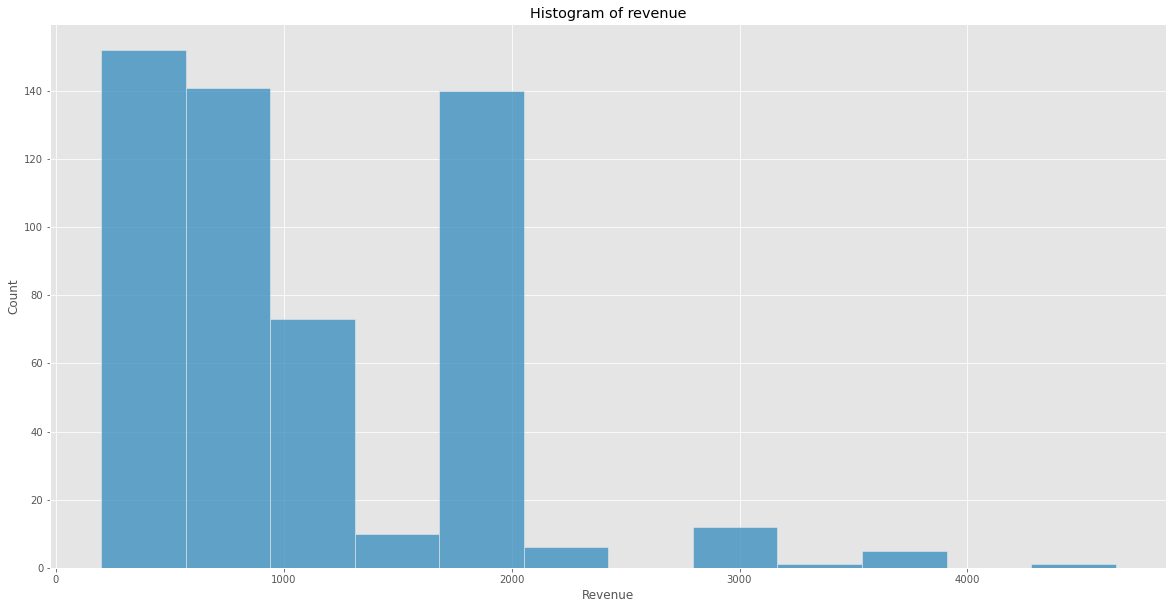

In [29]:
# посмотрим распределения покупкак среди покупающих пользователей
plt.figure(figsize=(20, 10))
sns.histplot(x='rev', data=checks)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title("Histogram of revenue")
plt.show()

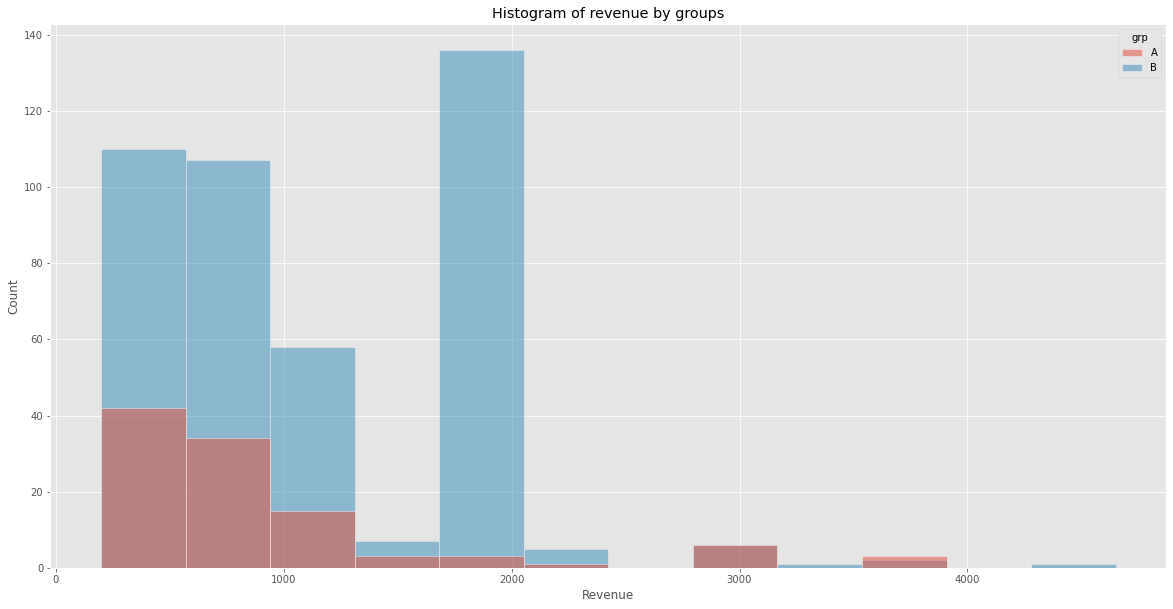

In [30]:
# построение распределения данных групп о покупках среди покупающих пользователей
plt.figure(figsize=(20, 10))
sns.histplot(x=active_checks.rev, hue=active_checks.grp)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title("Histogram of revenue by groups")
plt.show()

### Из графиков мы видим, что наши распределения далеки от нормальных, а значит применение Т-теста недопустимо.
### Можно было логарифмировать наши данные и наши распределения стали бы похожи на нормальные, но это приведет к трудностям в интерпретации для бизнеса. По этой же причине я не стал применять непараметрический U-критерий Манна — Уитни.
### В данной ситуации считаю оптимальным применение Бутсрапа. 


## Воспользуемся бутсрапом для сравнения средних

In [31]:
def get_bootstrap(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок
        statistic=np.median,  # интересующая нас статистика
        bootstrap_conf_level=0.99):  # уровень значимости
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        boot_data.append(statistic(samples_2 - samples_1))  # применяем статистику
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    #  Визуализация
    plt.figure(figsize=(20, 10))
    #  plt.hist()
    sns.histplot(x=pd_boot_data[0], bins=50)
    #  plt.style.use('ggplot')    
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

100%|██████████| 10000/10000 [00:03<00:00, 2606.29it/s]


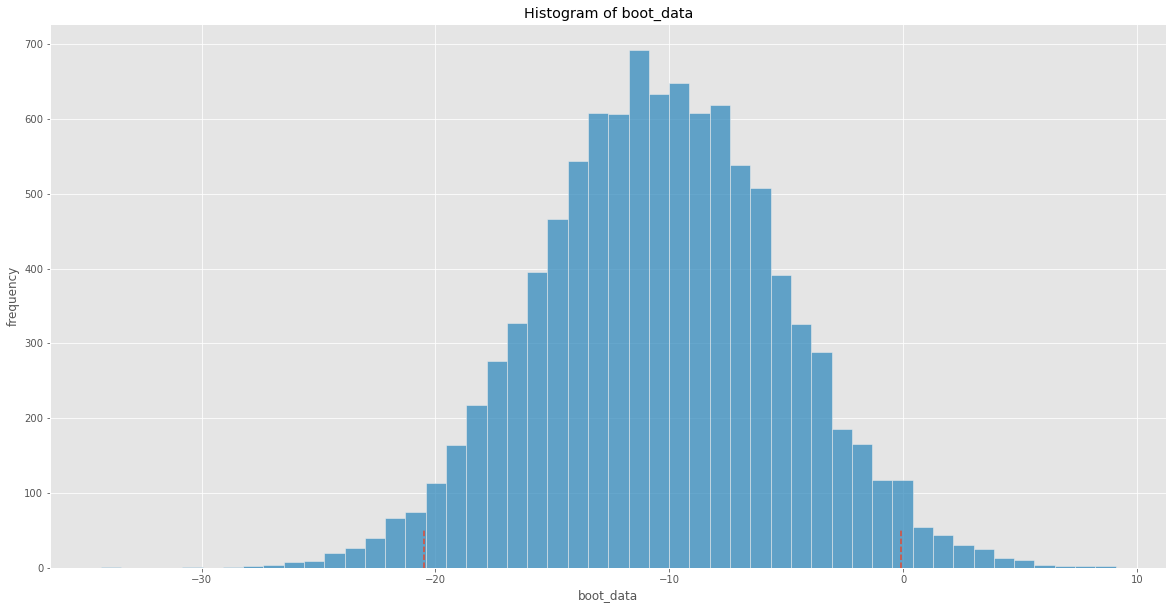

In [32]:
booted_data = get_bootstrap(
    active_groups_checks[active_groups_checks.grp == "B"].rev,  # числовые значения первой выборки
    active_groups_checks[active_groups_checks.grp == "A"].rev,  # числовые значения второй выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95)  # уровень значимости

In [33]:
booted_data['p_value']

0.04580811398413973

### p-value > 0.01 не отклоняем Н0 о равенстве средних в группах

## Воспользуемся бутсрапом для сравнения ARPPU

100%|██████████| 10000/10000 [00:01<00:00, 5397.28it/s]


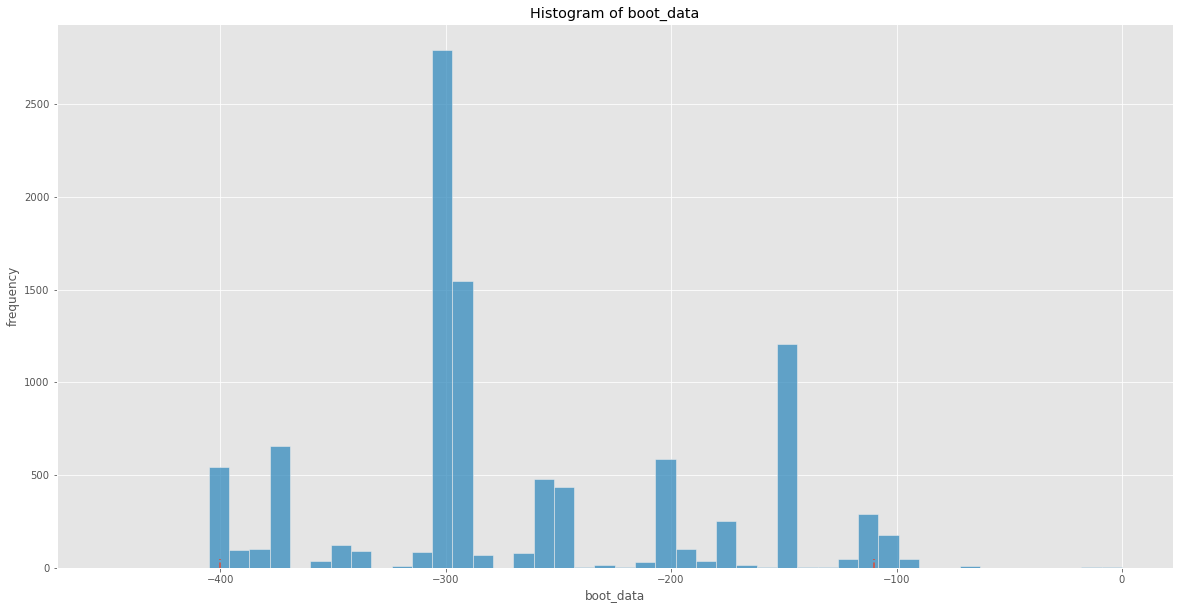

In [34]:
booted_data = get_bootstrap(
    active_checks[active_checks.grp == "B"].rev,  # числовые значения первой выборки
    active_checks[active_checks.grp == "A"].rev,  # числовые значения второй выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.median,  # интересующая нас статистика
    bootstrap_conf_level=0.95)  # уровень значимости

In [35]:
booted_data['p_value']

0.0007773035193547634

In [36]:

booted_data['ci']

,0
0.025,-400.0
0.975,-110.0


### Бутстрап показал p > 0,01 , 0 не входит в доверительный интервал, значит  мы НЕ принимаем нулевую гипотезу о том, что ARPPU в группах A и B не отличается.

## Посчитаем по группам ARPPU

In [37]:
print('ARPPU груп А', (active_checks.query('grp == "A"').rev.sum()) / (active_checks.query('grp == "A"').id.nunique()))
print('ARPPU груп B', (active_checks.query('grp == "B"').rev.sum()) / (active_checks.query('grp == "B"').id.nunique()))

ARPPU груп А 860.7102803738318
ARPPU груп B 1106.9976988452656


In [38]:
# посчитаем на сколько процентов различается ARPPU
A_ARPPU = active_checks.query('grp == "A"').rev.sum() / active_checks.query('grp == "A"').id.nunique()
B_ARPPU = active_checks.query('grp == "B"').rev.sum() / active_checks.query('grp == "B"').id.nunique()
print('ARPPU целевой группы больше на', round(((B_ARPPU - A_ARPPU) / A_ARPPU * 100), 1), '%')

ARPPU целевой группы больше на 28.6 %


## Посмотрим на конверсию в наших группах

In [39]:
conv_table = pd.crosstab(active_groups_checks.grp, active_groups_checks.purchase)
conv_table[1] / conv_table[0]

grp
A    0.053535
B    0.048302
dtype: float64

## Мы видим разницу в конверсии по группам. 

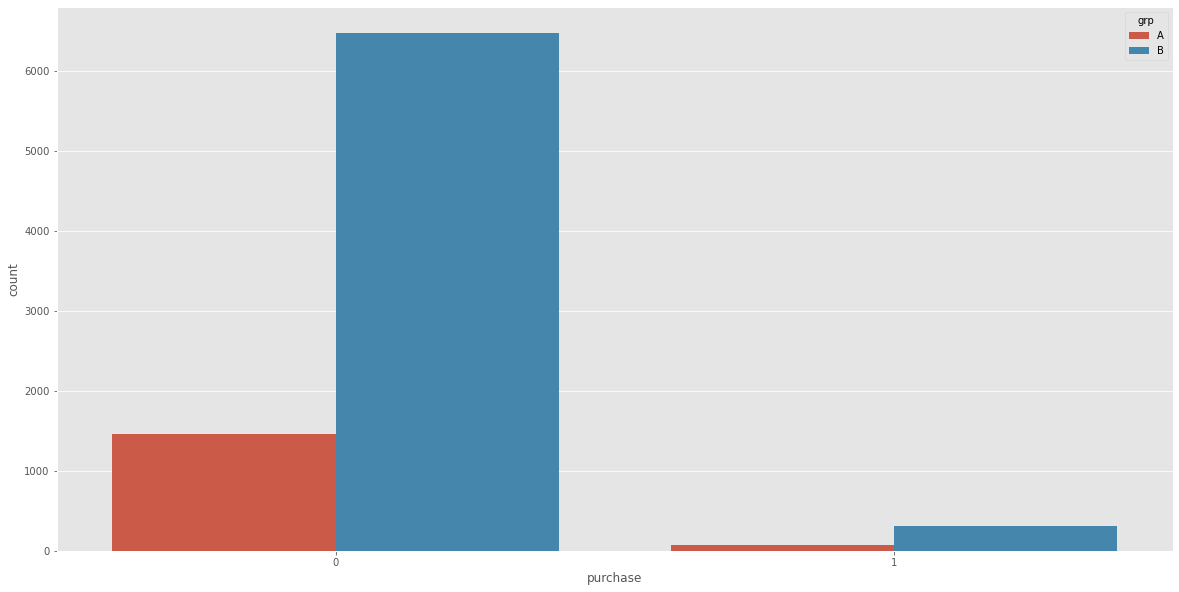

In [40]:
# Построим график конверсии
plt.figure(figsize=(20, 10))
sns.countplot(x="purchase", hue="grp", data=active_groups_checks)
plt.show()

###  Проверим зависит ли конверсия от принадлежности к группе.

### Т.к. у нас две номенативные переменные  (принадлежность к группе и наличие покупки)  я буду испльзовать ХИ квадрат Пирсона

### Н0 - связи между конверсией и групповой принадлежностью нет

In [41]:
stat, p, dof, expected = stats.chi2_contingency(conv_table)
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print('p-value =', round(stat, 2)) 

p-value = 0.53


### p-value > 0.01 не отклоняем Н0 о том, что связи между конверсиией и принадлежности нет.

## Выводы по анализу проведённого А/В теста:
### ХИ-квадрат Пирсона для проверки конверсии в покупку, бутсрап для сравнения средних показали отсутствие статистически значимых различий. 
### Бутсрап для сравнения ARPPU показал, что статистически значимые различия в группах есть.




## Т.к.  ARPPU  целевой группы больше на 28.6 % стоит запускать новую механику оплаты на всех пользователей.


# Задание 2. SQL

### 2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.


2.1.2 Задача

Дана таблица peas:

```
Название атрибута   Тип атрибута    Смысловое значение

st_id	            int	ID          ученика
timest	            timestamp       Время решения карточки
correct	            bool            Правильно ли решена горошина?
subject	            text            Дисциплина, в которой находится горошина
```

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

# Запрос


### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: peas (см. выше), studs:

Название атрибута	Тип атрибута 	Смысловое значение
st_id	int 	ID ученика
test_grp	text 	Метка ученика в данном эксперименте
и final_project_check:

Название атрибута	Тип атрибута 	Смысловое значение
st_id	int 	ID ученика
sale_time	datatime	Время покупки
money	int	Цена, по которой приобрели данный курс
subject	text 	Дисциплина, на которую приобрели полный доступ
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
Все данные находятся в табличном виде в Clickhouse




# Запрос

## Задание 3. Python

### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [42]:
def groups_add(groups, active_studs, checks):
    """
    Функция автоматически подгружает информацию из дополнительного файла groups_add.csv и считает метрики.
    """
    """ считываем дополнительный фаил """  
    public_key_groups_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))
    response_groups_add = requests.get(final_url_groups_add)
    download_url_groups_add = json.loads(response_groups_add.text)['href']
    groups_add = pd.read_csv(download_url_groups_add, sep=',')  
    """Т.к. заголовки таблицы могут отличаться переименуем их в удобные нам названия"""   
    groups_add.rename(columns=({groups_add.columns[0]: 'id', groups_add.columns[1]: 'grp'}), inplace=True)   
    """Добавим да переименованный датафрейм к датарейму groups"""
    full_groups = groups.append(groups_add)
    """переименовываем колонки"""
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)
    """добавляем метку '1' для активных студентов"""
    active_studs['active'] = 1
    """объединяем датафреймы"""
    full_data = pd.merge(full_groups, active_studs, how='left')
    full_data = pd.merge(full_data, checks, how='left')
    full_data = full_data.fillna(0)
    conv_table = pd.crosstab(active_groups_checks.grp, active_groups_checks.purchase)
    """считаем метрики"""
    arppu = pd.DataFrame({'grp': ['A', 'B'],
                          'ARPPU': [
                              full_data.query('grp == "A"').rev.sum() / full_data.query('grp == "A"').id.nunique(),
                              full_data.query('grp == "B"').rev.sum() / full_data.query('grp == "B"').id.nunique()]})
    avg_check = pd.DataFrame({'grp': ['A', 'B'],
                              'avg_check': [round(full_data.query('grp == "A" & rev > 0').rev.mean(), 1),
                                            round(full_data.query('grp == "B" & rev > 0').rev.mean(), 1)]})
    conversion = pd.DataFrame(conv_table[1] / conv_table[0]) \
        .reset_index() \
        .rename(columns={0: 'cr'})
    return {'arppu': arppu,
            'avg_check': avg_check,
            'conversion': conversion}

In [43]:
metrics = groups_add(groups, checks, active_studs)

In [44]:
metrics['arppu']

,grp,ARPPU
0,A,6.268019
1,B,8.036171


### Реализуем функцию, которая будет строить графики по получаемым метрикам.

In [45]:
def get_graf(metrics):  
    """функция, которая будет строить графики по получаемым метрикам. """       
    plt.figure(figsize=(20, 9))
    """ график ARPPU """
    plt.subplot(1, 3, 1)
    bar = sns.barplot(x='grp', y='ARPPU', data=metrics['arppu'])
    bar.axes.set_title('ARPPU', fontsize=16)
    bar.set_xlabel('Group', fontsize=12)
    bar.set_ylabel('ARPPU', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12) 
    """ график  средних AVG """
    plt.subplot(1, 3, 2)
    bar = sns.barplot(x='grp', y='avg_check', data=metrics['avg_check'])
    bar.axes.set_title('AVG', fontsize=16)
    bar.set_xlabel('Group', fontsize=12)
    bar.set_ylabel('Checks', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)  
    """ график CR"""
    plt.subplot(1, 3, 3)
    bar = sns.barplot(x='grp', y='cr', data=metrics['conversion'])
    bar.axes.set_title("Conversion", fontsize=16)
    bar.set_xlabel('Group', fontsize=12)
    bar.set_ylabel('CR ', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)    

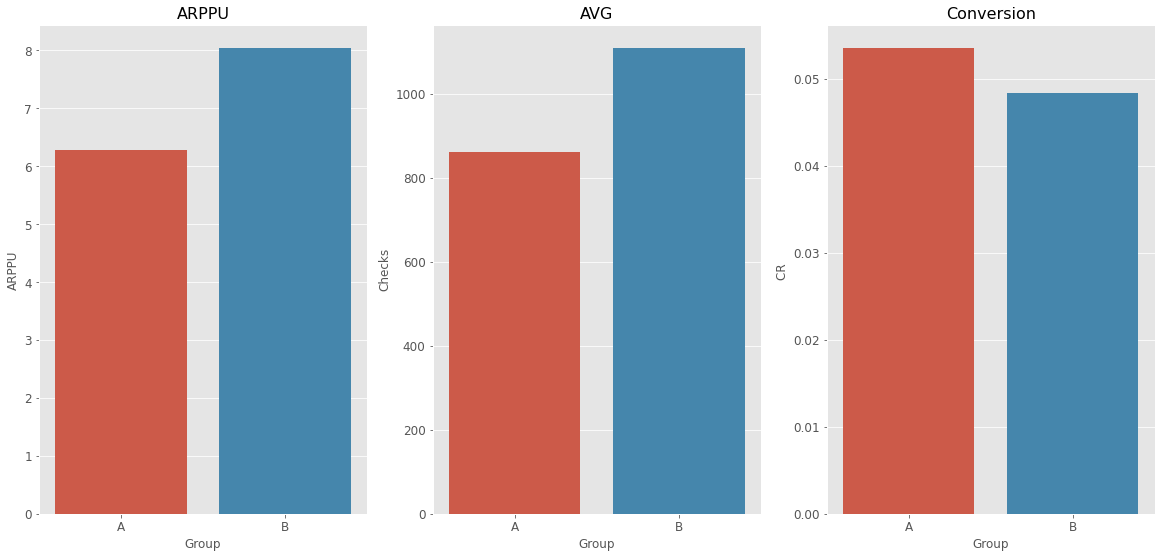

In [46]:
get_graf(metrics)